# Lab 1: El Niño Southern Oscillation
Connor Sughrue <br>
March 3, 2021 <br>
DATA 330 - Applied Time Series Analysis

### Introduction

*Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle* <br>
https://doi.org/10.3390/ijerph16173146

The El Niño Southern Oscillation (ENSO) can have a drastic impact on climate patterns. El Niño can alter air temperature, precipitation patterns and other extremes. These changes have demonstrably caused public health crises in many regions of the world. For example, there is a well-established links between ENSO and climate-sensitive infectious diseases such as cholera and malaria. By applying time-series regression to datasets from the EM-DAT International Disaster Database, the researchers studied the relationship between two ENSO indices, the Oceanic Niño Index (ONI) and the multivariate El Niño Index (MEI), and public health crises. Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle is motivated by the need to better understand ENSO’s impact so that communities can be better prepared for disaster.

The two ENSO indices, ONI and MEI, were obtained from the National Oceanic and Atmospheric Administration (NOAA). ONI is a three-month moving average of sea surface temperature anomalies in the Niño 3.4 region of the equatorial Pacific. ONI represents a deviation from the expected temperature and is a common metric used to define an El Niño event. The NOAA defines an El Niño event as a period with at least five consecutive overlapping three-moth periods of an ONI greater than + 0.5 °C. MEI is a two-month seasonal index which integrates sea-level pressure, zonal and meridional components of the surface wind, sea surface temperature, surface air temperature, and total cloudiness fraction of the sky. Like ONI, MEI represents a deviation from what is normal that time of year. Positive values indicate an El Niño event, and the higher the value the stronger the El Niño event. For the analysis, the combination of Poisson Generalized Additive Models (GAMs) and distributed-lag non-linear models for time-series data were used to model nonlinear and lag effects.

In general, the study suggested that “ENSO plays a role, via climate related hazards, in determining health burdens.” Meaning that there is a connection between ENSO and public health crises due to natural disasters caused by the changing climate patterns. Interestingly the type of natural disaster and location affected varies along with the state of an ENSO event. Higher ONI and MEI values were associated with the risk of flood-related disasters while lower ONI and MEI values were associated with the risk of storm related disasters. Also, of the countries assessed, India seemed most vulnerable to floods during and following higher ONI and MEI values and the Philippines were most vulnerable to floods during and following lower ONI and MEI values. Information regarding the relationship between ENSO and public health crises will help improve early warning systems and other protections measures so regions can be more prepared for natural disasters.

### Data Processing

In order to counduct our analysis the data sets must be processed and loaded into a dataframe.

In [1]:
install.packages('tswge')
library('tswge')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#### Persons Affected by Disasters (PAD)

Data from EM-DAT International Disaster Database. <br>
Data was downloaded for all regions between 1964 and 2017 and for all disaster types except for the following:

* Technological
* Complex
* Extra-Terrestrial (Natural)
* Geophysical (Natural)

In [2]:
# load in PAD dataset
location  <- "https://raw.githubusercontent.com"
username  <- "cpsughrue"
repo      <- "DATA330_Lab1"
branch    <- "main"
folder    <- "data"
file.name <- "PAD.csv"

PAD.location = paste(location, username, repo, branch, folder, file.name, sep = '/')
PAD.df <- read.csv(PAD.location)

# subset dataset on desired columns
cols.interest <- c("Country", "ISO", "Start.Year", "Start.Month", 
                   "End.Year", "End.Month", "Total.Deaths", "Declaration", 
                   "OFDA.Response", "Total.Affected")

PAD.df <- PAD.df[cols.interest]

In [3]:
# to calculate PAD download regional population data from the WorldBank
# downlown World Bank zip file with country population
wbank.url <- "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
wbank.name <- "world_bank.zip"
wbank.file <- paste("/tmp/", wbank.name, sep = "")
download.file(wbank.url, wbank.file)

# unzip world bank file
unzip(zipfile = wbank.file, exdir = "/tmp")

# read in world bank file
wb.file <- "API_SP.POP.TOTL_DS2_en_csv_v2_2106202.csv"
wb.file.address <- paste("/tmp/", wb.file, sep="")
wb.df <- read.csv(wb.file.address, header = TRUE, skip = 4)

In [4]:
# Loop through each row of PAD.df
# find the matching country and year
# add population to PAD.df
for (pad_row in 1:nrow(PAD.df)) {

  iso <- PAD.df[pad_row, ][['ISO']]
  year <- PAD.df[pad_row, ][['Start.Year']]
  col <- paste("X", year, sep="")

  # match returns row index if match and "NA" if no match
  wb_row <- match(iso, wb.df$Country.Code)

  # if match exists add country population to PAD.df
  if (!is.na(wb_row)) {
    pop <- wb.df[, col][wb_row]
    PAD.df[pad_row, 'POP'] = pop
  } 
  else {
    PAD.df[pad_row, 'POP'] = NA
  }
}

In [5]:
# calculate the PAD per 1000
all.population <- rep(c(0), times = length(unique(PAD.df$Start.Year)))
all.affected <- rep(c(0), times = length(unique(PAD.df$Start.Year)))

num.unique.years <- length(unique(PAD.df$Start.Year))

for (year.index in 1:num.unique.years){
  
  year <- unique(PAD.df$Start.Year)[year.index]
  year.df <- PAD.df[PAD.df$Start.Year == year, ]

  # calculate total population for specific year
  # identify rows to subset on (unique countries)
  population.rows <- !duplicated(year.df$ISO)
  populations <- year.df[population.rows, ]$POP
  total.population <- sum(na.omit(populations))
  all.population[year.index] <- total.population
  
  # calculate total affected for specific year
  # identify rows to subset on ('Total.Affected' and 'POP' do not contain NA)
  affected.rows <- !is.na(year.df$Total.Affected) & !is.na(year.df$POP)
  affected <- year.df[affected.rows, ]$Total.Affected
  total.affected <- sum(na.omit(affected))
  all.affected[year.index] <- total.affected
}

PAD <- (all.affected / all.population) * 1000

#### Oceanic Niño Index (ONI)

Tabularized Oceanic Niño Index (ONI) from NOAA. <br>
The data can be found online in two different formats:
* https://psl.noaa.gov/data/correlation/oni.data
* https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt

In [6]:
# define the URL and download to /tmp
ONI.url <- "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
ONI.name <- "oni.ascii.txt"
ONI.file <- paste("/tmp/", ONI.name, sep="")
download.file(ONI.url, ONI.file, method = 'auto')

ONI.df <- read.table(ONI.file, header = TRUE)

#### Multi-variate ENSO Index (MEI)

Multivariate El Niño/Southern Oscillation (ENSO) Index (MEI) Version 1 <br>
The data and additional information can be found respectivly:
* https://psl.noaa.gov/enso/mei.ext/table.ext.html 
* https://psl.noaa.gov/enso/mei.old/

In [7]:
MEI.url <- "https://psl.noaa.gov/enso/mei.old/table.html"
MEI.name <- "table.html"
MEI.file <- paste("/tmp/", MEI.name, sep="")
download.file(MEI.url, MEI.file, method = 'auto')

In [8]:
# identify column names from the data
text.file <- readLines(MEI.file)
for (my.line in text.file){

  # only row of column names begins with YEAR
  # grep uses regular expressions for pattern matching
  int <- grep("^YEAR.*", my.line)
  if (length(int) > 0) {
    my.cols <- unlist(strsplit(my.line, "\\s+"))
  }
}

In [9]:
# Create an empty dataframe
n.cols <- length(my.cols)
MEI.df <- data.frame(matrix(ncol = n.cols, nrow = 0))
colnames(MEI.df) <- my.cols 
#str(MEI.df)

In [10]:
# Get all the data lines
text.file <- readLines(MEI.file)

for (my.line in text.file){
  
  # only rows of data begin with an integer between 0 and 9
  a <- grep("^[0-9].*", my.line)
  
  if (length(a) > 0) {

    # convert line of text into vector of numbers
    str.data <- unlist(strsplit(my.line, "\\s+"))
    num.data <- as.numeric(str.data) 

    if (length(num.data) == n.cols) {
      # insert data into MEI.df
      MEI.df[nrow(MEI.df) + 1, ] <- c(num.data)
    }
  }
}

In [11]:
MEI.values <- MEI.df[, 2:length(my.cols)]
MEI.values.t <- t(MEI.values)
MEI.vect <- as.vector(MEI.values.t)


MEI.ts <- ts(MEI.vect, start = c(1950, 1), frequency = 12)

### Fig. 1 Replication

Annual time-series of ONI, MEI, and rates of people affected by natural disasters (PAD per 1000). <br>
Global. Yearly data from NOAA and EM-DAT, 1964–2017.

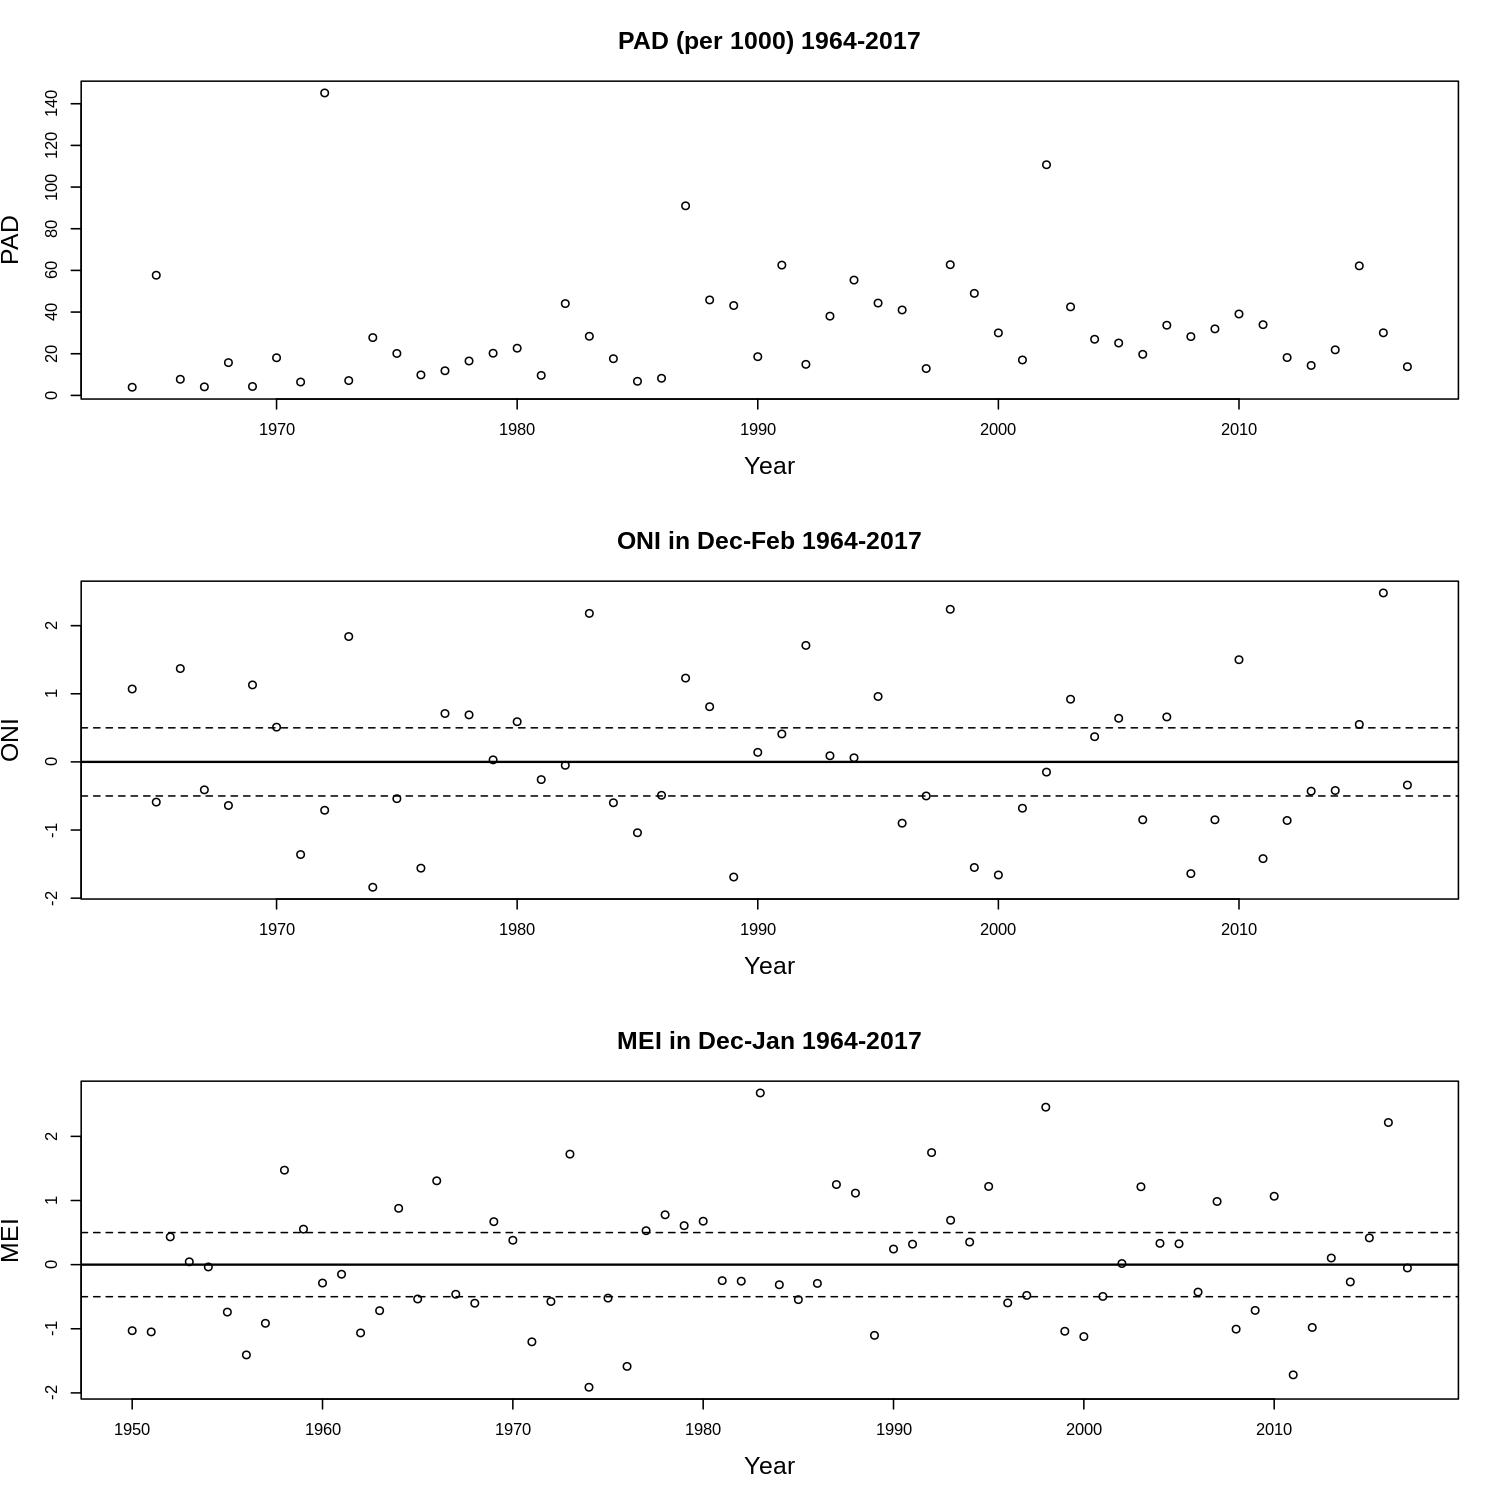

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 150)
par(mfrow = c(3,1))

plot(unique(PAD.df$Start.Year), PAD, main = "PAD (per 1000) 1964-2017",
                                     xlab = "Year",
                                     ylab = "PAD",
                                     cex.main = 1.5,
                                     cex.lab = 1.5)

ONI.filter <- ONI.df[ONI.df$SEAS == 'DJF' & ONI.df$YR > 1963 & ONI.df$YR < 2018, ]
plot(ONI.filter$YR, ONI.filter$ANOM, main = "ONI in Dec-Feb 1964-2017",
                                     xlab = "Year",
                                     ylab = "ONI",
                                     cex.main = 1.5,
                                     cex.lab = 1.5)
abline(h = 0, lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = -0.5, lty = 2)

plot(MEI.df$YEAR, MEI.df$DECJAN, main = "MEI in Dec-Jan 1964-2017",
                                 xlab = "Year",
                                 ylab = "MEI",
                                 cex.main = 1.5,
                                 cex.lab = 1.5)

abline(h = 0, lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = -0.5, lty = 2)

### Exploritory Analysis

Investigate all three data sets using the sample autocorrelation and periodogram plots

In [13]:
# define a function to help graph plots

exploritory.plots <- function(ts.data, lag.max, l, main.plot, main.acf, ylab){
  
  options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 150)
  par(mfrow = c(4,1))

  plot(ts.data, main = main.plot,
                xlab = "Year",
                ylab = ylab)

  if (l == TRUE){
    abline(h = 0, lwd = 1.5)
    abline(h = 0.5, lty = 2)
    abline(h = -0.5, lty = 2)
  }


  acf(ts.data, lag.max = lag.max, type = "correlation", 
                                  main = main.acf, 
                                  ylab = "Sample Autocorrelation")

  plot.period <- period.wge(ts.data, plot = TRUE)

  plot.parzen <- parzen.wge(ts.data, plot = TRUE)
}

#### PAD Plots

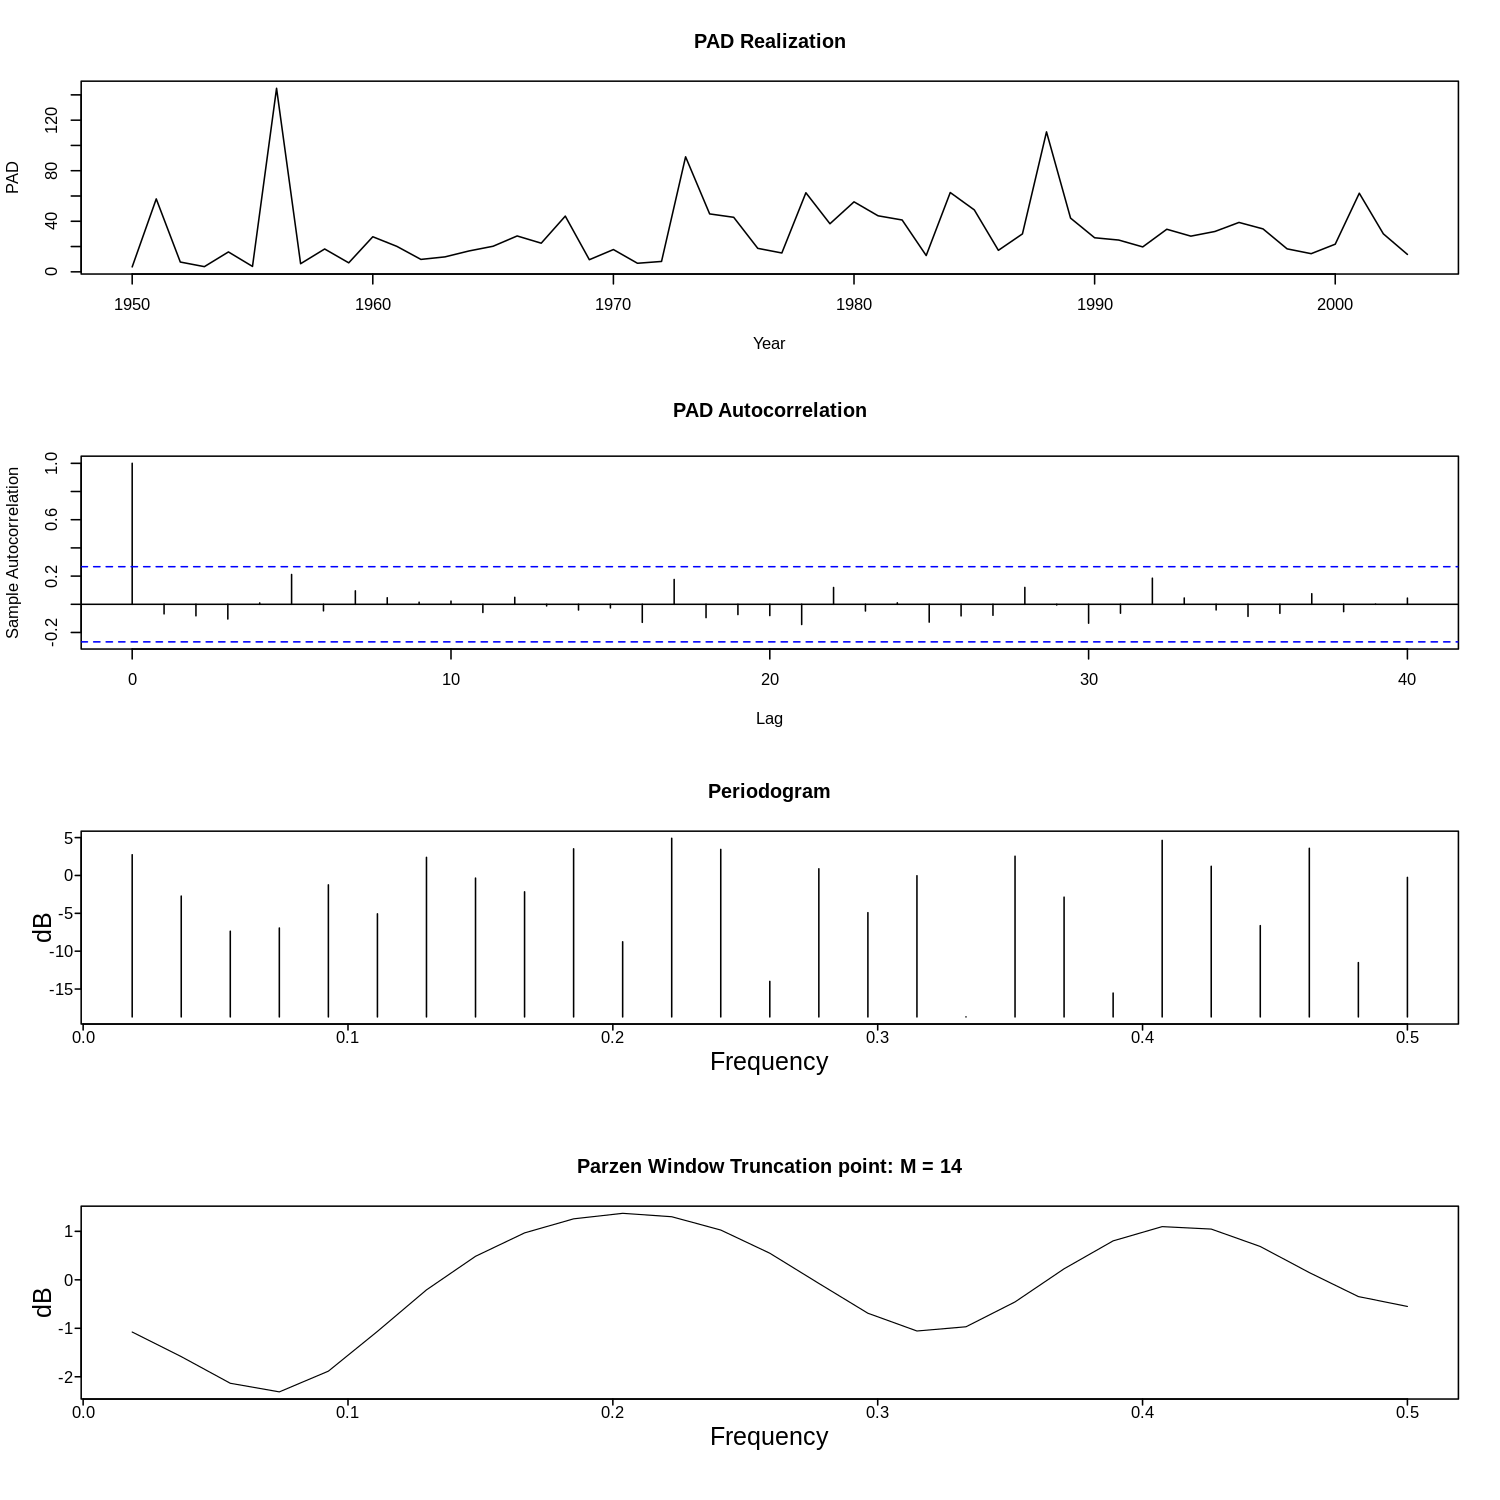

In [14]:
PAD.ts <- ts(PAD, start = c(1950,1))

exploritory.plots(PAD.ts, lag.max = 40, l = FALSE, main.plot = "PAD Realization", 
                                                   main.acf = "PAD Autocorrelation", 
                                                   ylab = "PAD")

By looking at the spectral density plot you can see two clear periods.

In [15]:
PAD.period <- period.wge(PAD.ts, plot = FALSE)

len <- length(PAD.period$pgram)

PAD.f1.index <- which.max(PAD.period$pgram)
PAD.f1 <- PAD.period$freq[PAD.f1.index]

PAD.f2.start <- PAD.f1.index + 1
PAD.f2.offset <- which.max(PAD.period$pgram[PAD.f2.start:len])
PAD.f2.index <- PAD.f2.offset + PAD.f1.index
PAD.f2 <- PAD.period$freq[PAD.f2.index]

cat('Frequency 1:', PAD.f1, '\n')
cat('Period 1:', 1/PAD.f1, '\n\n')

cat('Frequency 2:', PAD.f2, '\n')
cat('Period 2:', 1/PAD.f2, '\n\n')

Frequency 1: 0.2222222 
Period 1: 4.5 

Frequency 2: 0.4074074 
Period 2: 2.454545 



#### ONI Plots

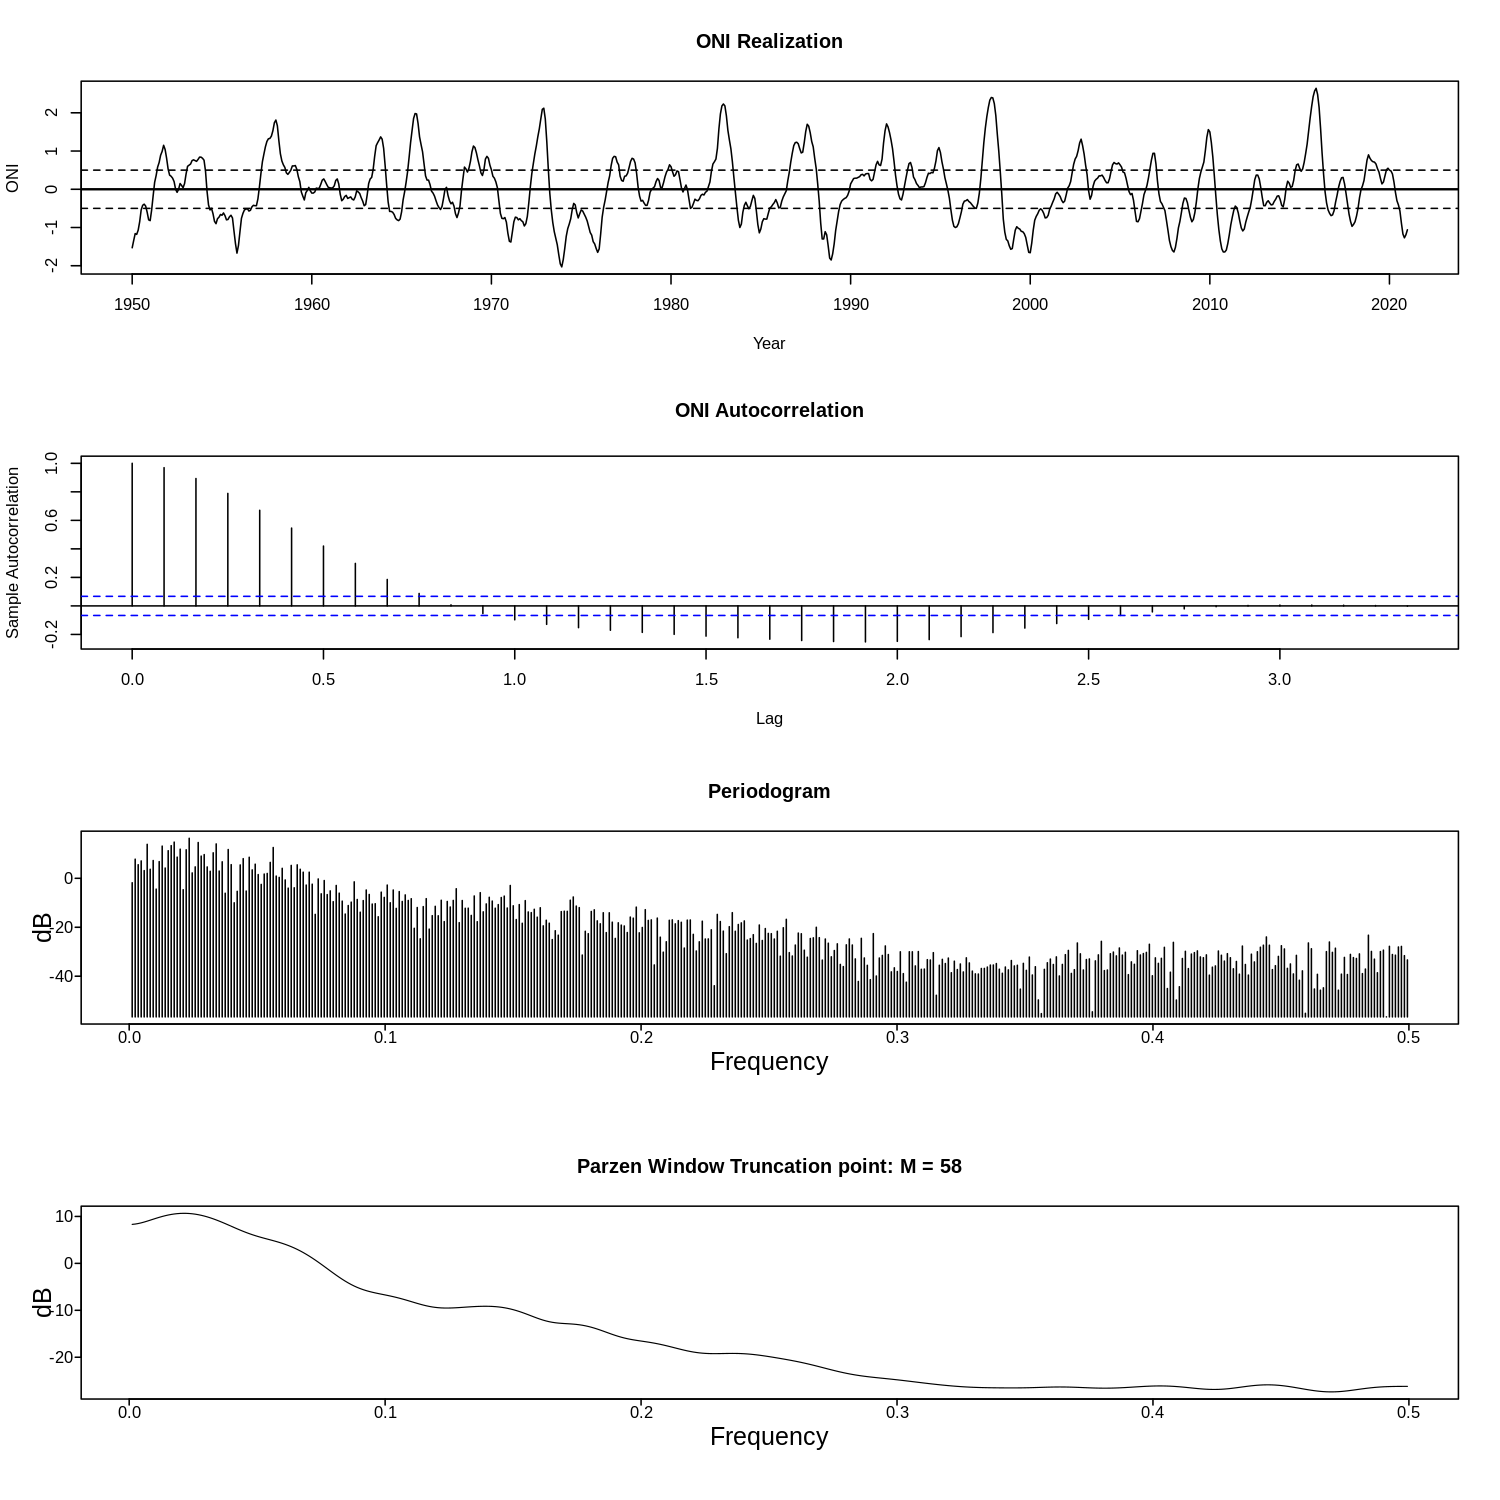

In [16]:
# does not just include December, January, and Feburary
ONI.ts <- ts(ONI.df$ANOM, start = c(1950, 1), frequency = 12)

exploritory.plots(ONI.ts, lag.max = 40, l = TRUE, main.plot = "ONI Realization", 
                                                  main.acf = "ONI Autocorrelation", 
                                                  ylab = "ONI")

The frequencies are less clear in ONI's spectral density plot.

In [17]:
ONI.period <- period.wge(ONI.ts, plot = FALSE)

len <- length(ONI.period$pgram)

ONI.f1.index <- which.max(ONI.period$pgram)
ONI.f1 <- ONI.period$freq[ONI.f1.index]

cat('Frequency 1:', ONI.f1, '\n')
cat('Period 1:', 1/ONI.f1, '\n\n')

Frequency 1: 0.02344666 
Period 1: 42.65 



According to ONI's periodogram a period may exist every 42.65 years. However, considering our sample space is only 70 years it is fair to say no real period exists.

#### MEI Plots

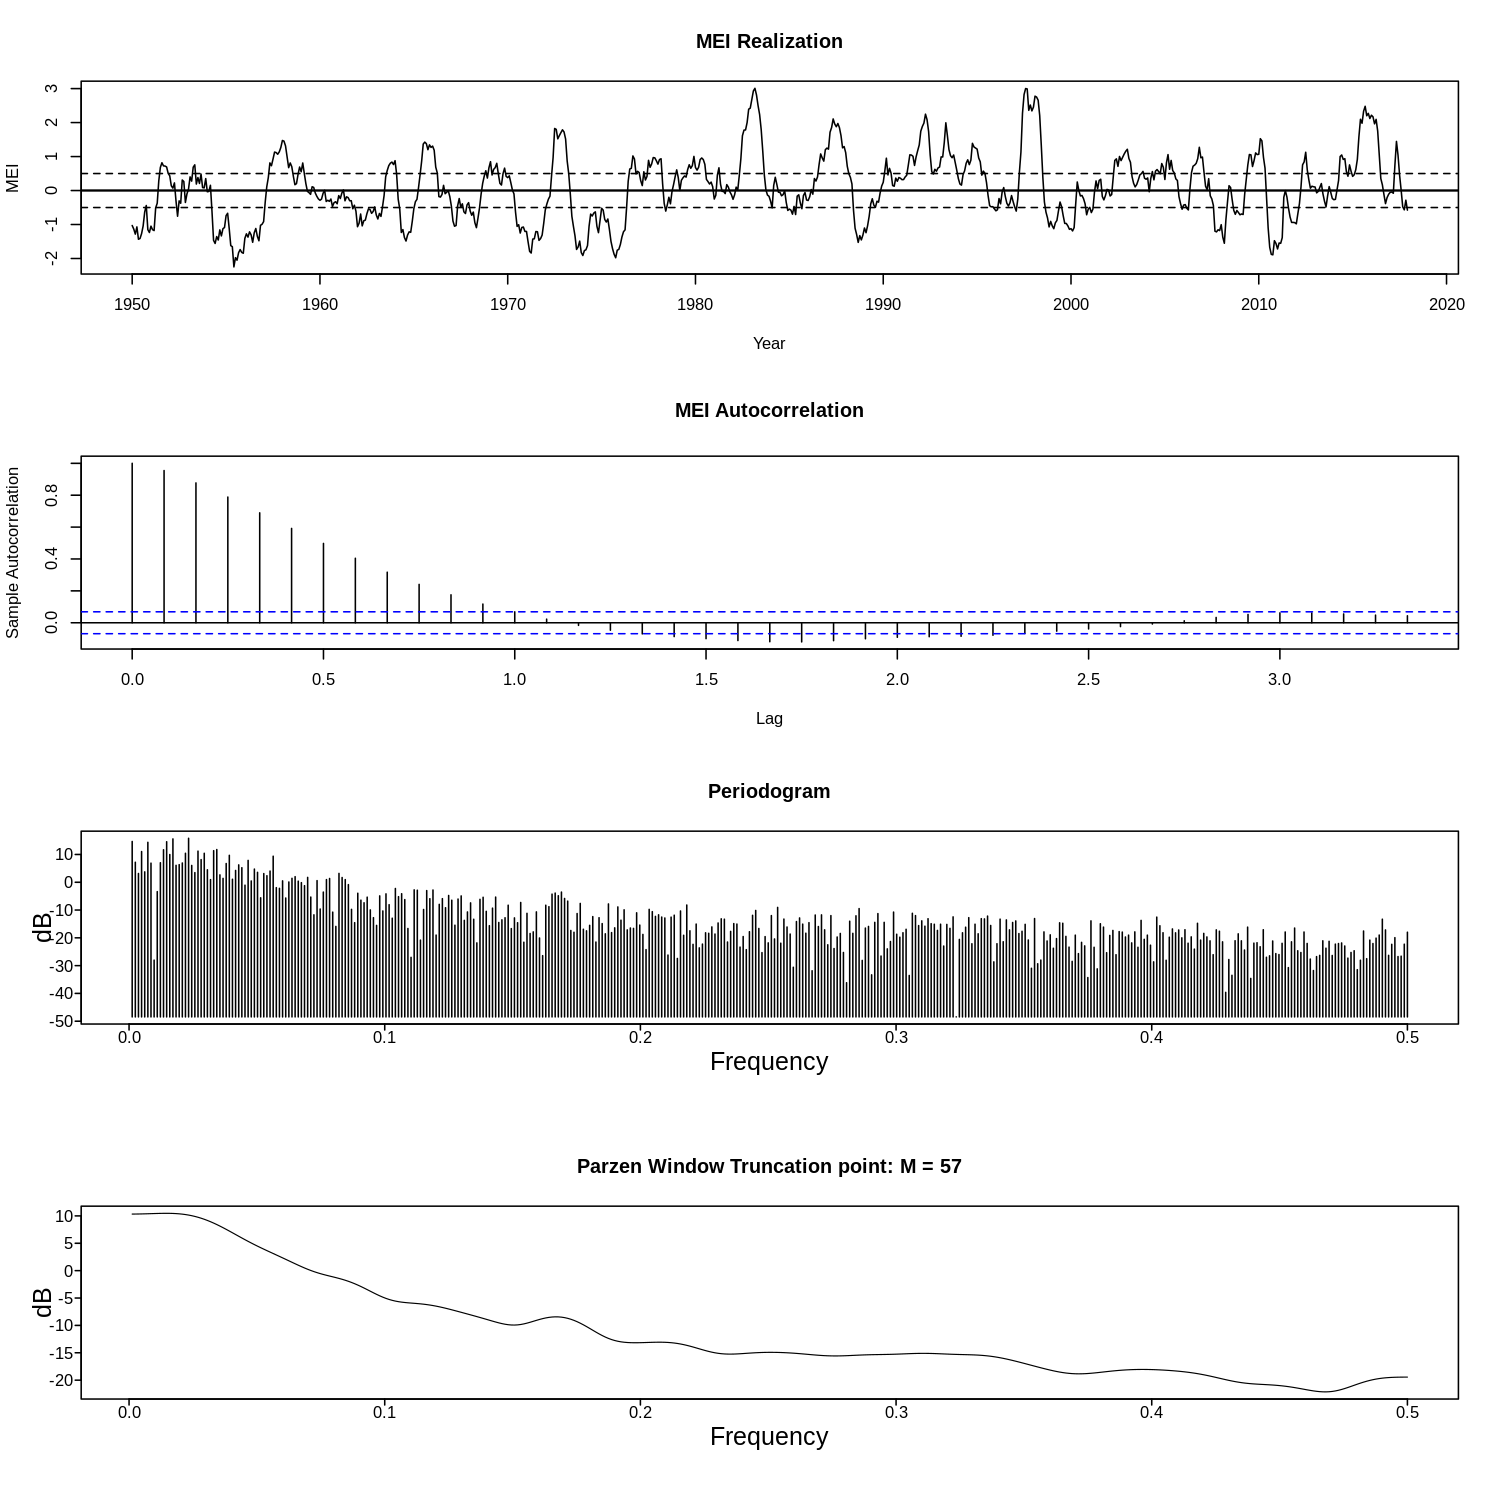

In [18]:
MEI.num.col <- length(colnames(MEI.df))
MEI.values <- MEI.df[, 2:MEI.num.col]
MEI.values.t <- t(MEI.values)
MEI.vect <- as.vector(MEI.values.t)

MEI.ts <- ts(MEI.vect, start = c(1950,1), frequency = 12)

exploritory.plots(MEI.ts, lag.max = 40, l = TRUE, main.plot = "MEI Realization", 
                                                  main.acf = "MEI Autocorrelation", 
                                                  ylab = "MEI")

In [19]:
MEI.period <- period.wge(MEI.ts, plot = FALSE)

len <- length(MEI.period$pgram)

MEI.f1.index <- which.max(MEI.period$pgram)
MEI.f1 <- MEI.period$freq[MEI.f1.index]

cat('Frequency 1:', MEI.f1, '\n')
cat('Period 1:', 1/MEI.f1, '\n\n')

Frequency 1: 0.02328431 
Period 1: 42.94737 



Once again the most significant frequency represents a period of over 40 years. Our sample space is not large enogh to confirm that a 42.9 year period exists.

### El Nino Years

Based on the metrics provided in *Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle* lets identify El Niño years and its dominant frequencies. Remember, El Niño event occurs when the ONI is higher than 0.5 °C for at least five consecutive overlapping three-month periods.

In [20]:
Nino.v <- ONI.df$ANOM

# replace ONI values less than .5 with NA

index <-1
for (element in Nino.v){

  if (element < .5){
    Nino.v[index] <- NA
    index <- index + 1
  }
  else{
    index <- index + 1
  }
}

# values is bollean vector
# TRUE represents value over .5 and FALSE represents value under .5
# len represents consecutive TRUE and FALSE as it applies to Nino.v

values <- rle(!is.na(Nino.v))$values
len <- rle(!is.na(Nino.v))$lengths

# if len < 5 set value to FALSE
# whether value is over .5 or under .5 
# if there is not 5 consecutive data points 
# the subset is not apart of El Nino event

index <- 1
for (element in len){

  if (element < 5){
    values[index] <- FALSE
    index <- index + 1
  }
  else{
    index <- index + 1
  }
}

# create boolean vector representing data points 
# that belong to El Nino event

Nino.mask <- rep(values, len)

# replaces values greater than .5 with FALSE 
# if they are not apart of  5 consecutive data points above .5

index <-1
for (element in Nino.mask){

  if (element == FALSE){
    Nino.v[index] <- NA
    index <- index + 1
  }
  else{
    index <- index + 1
  }
}

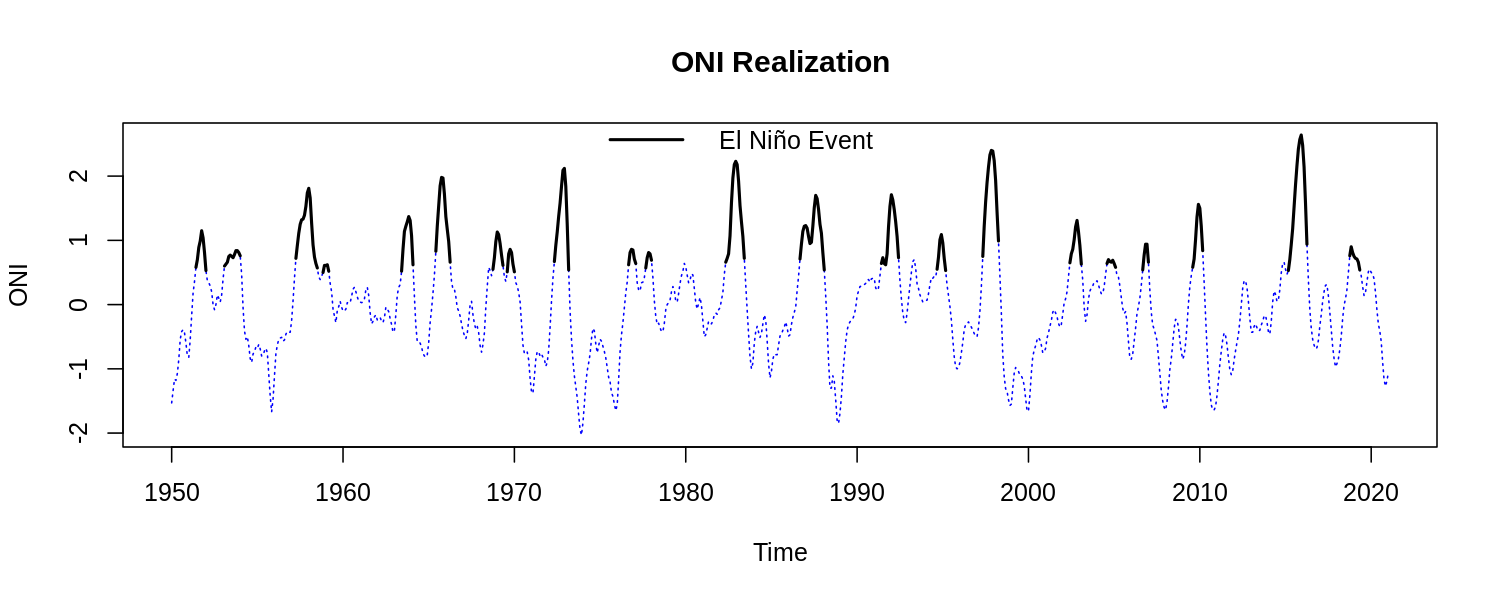

In [21]:
Nino.ts <- ts(Nino.v, c(1950,1), frequency = 12)
ONI.ts <- ts(ONI.df$ANOM, start = c(1950, 1), frequency = 12)

options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 150)

plot(ONI.ts, col = "blue", lwd = 1, lty = 3, main = "ONI Realization",
                                             ylab = "ONI")

lines(Nino.ts, lwd = 2, col = "black", ylim = c(-2.25, 3))

legend("top", 
       inset = 0.01, 
       col = c("black"), 
       lty = c(1), 
       lwd = c(2), 
       legend = c("El Niño Event"), 
       bg = "white",
       box.col = "white",
       horiz = TRUE)

List of all the years in which an El Niño event took place.

In [22]:
year <- c()
Nino.m <- matrix(as.vector(Nino.ts)[1:852], nrow = 71, byrow = TRUE)


index <- 1
for (row in 1:nrow(Nino.m)){
  
  numNotNA <- sum(!is.na(Nino.m[row, ]))

  if (numNotNA > 0){
    year <- c(year, unique(ONI.df$YR)[row])
  }
}

matrix(year, nrow = 7, byrow = TRUE)

1951,1952,1953,1954,1957,1958
1959,1963,1964,1965,1966,1968
1969,1970,1972,1973,1976,1977
1978,1982,1983,1986,1987,1988
1991,1992,1994,1995,1997,1998
2002,2003,2004,2005,2006,2007
2009,2010,2015,2016,2018,2019


List of all the years in which an El Niño event started.

In [23]:
Nino.data <- ONI.df$ANOM

# replace ONI values less than .5 with 0
# replace ONI values greater than .5 with 1

index <-1
for (element in Nino.data){

  if (element < .5){
    Nino.data[index] <- 0
    index <- index + 1
  }
  else{
    Nino.data[index] <- 1
    index <- index + 1
  }
}

# blocks represents number of consecutive 0s and 1s in Nino.data
# creat a vector, cumulativeLengths, with first index of each sequence

blocks <- rle(Nino.data)$lengths

cumulativeLengths <- c()
num <- 0

for (block in blocks){
  num <- num + block
  
  cumulativeLengths <- c(cumulativeLengths, num)
}

# vector of 1s and 0s
# 1s represent month during El Nino event
# 0s represent month not during El Nino event
# create vector, startYears, with index of start year

binary <- rle(Nino.data)$values

index <- 1
startPoints <- c()
for (num in binary){

  if (num == 1){
    startPoints <- c(startPoints, cumulativeLengths[index])
    index <- index + 1
  }
  else{
    index <- index + 1
  }
}

startYears <- ONI.df$YR[startPoints]
matrix(startYears, nrow = 3, byrow = TRUE)

1952,1954,1958,1959,1964,1966,1968,1969,1970
1973,1977,1978,1980,1983,1988,1992,1993,1995
1998,2003,2005,2007,2010,2015,2016,2019,2020


Now lets see if we can find a dominant frequency. First lets look at a realization where any month pertaining to an El Niño event is coded as a 1 and any month not pertaining to an El Niño event is coded as a 0.

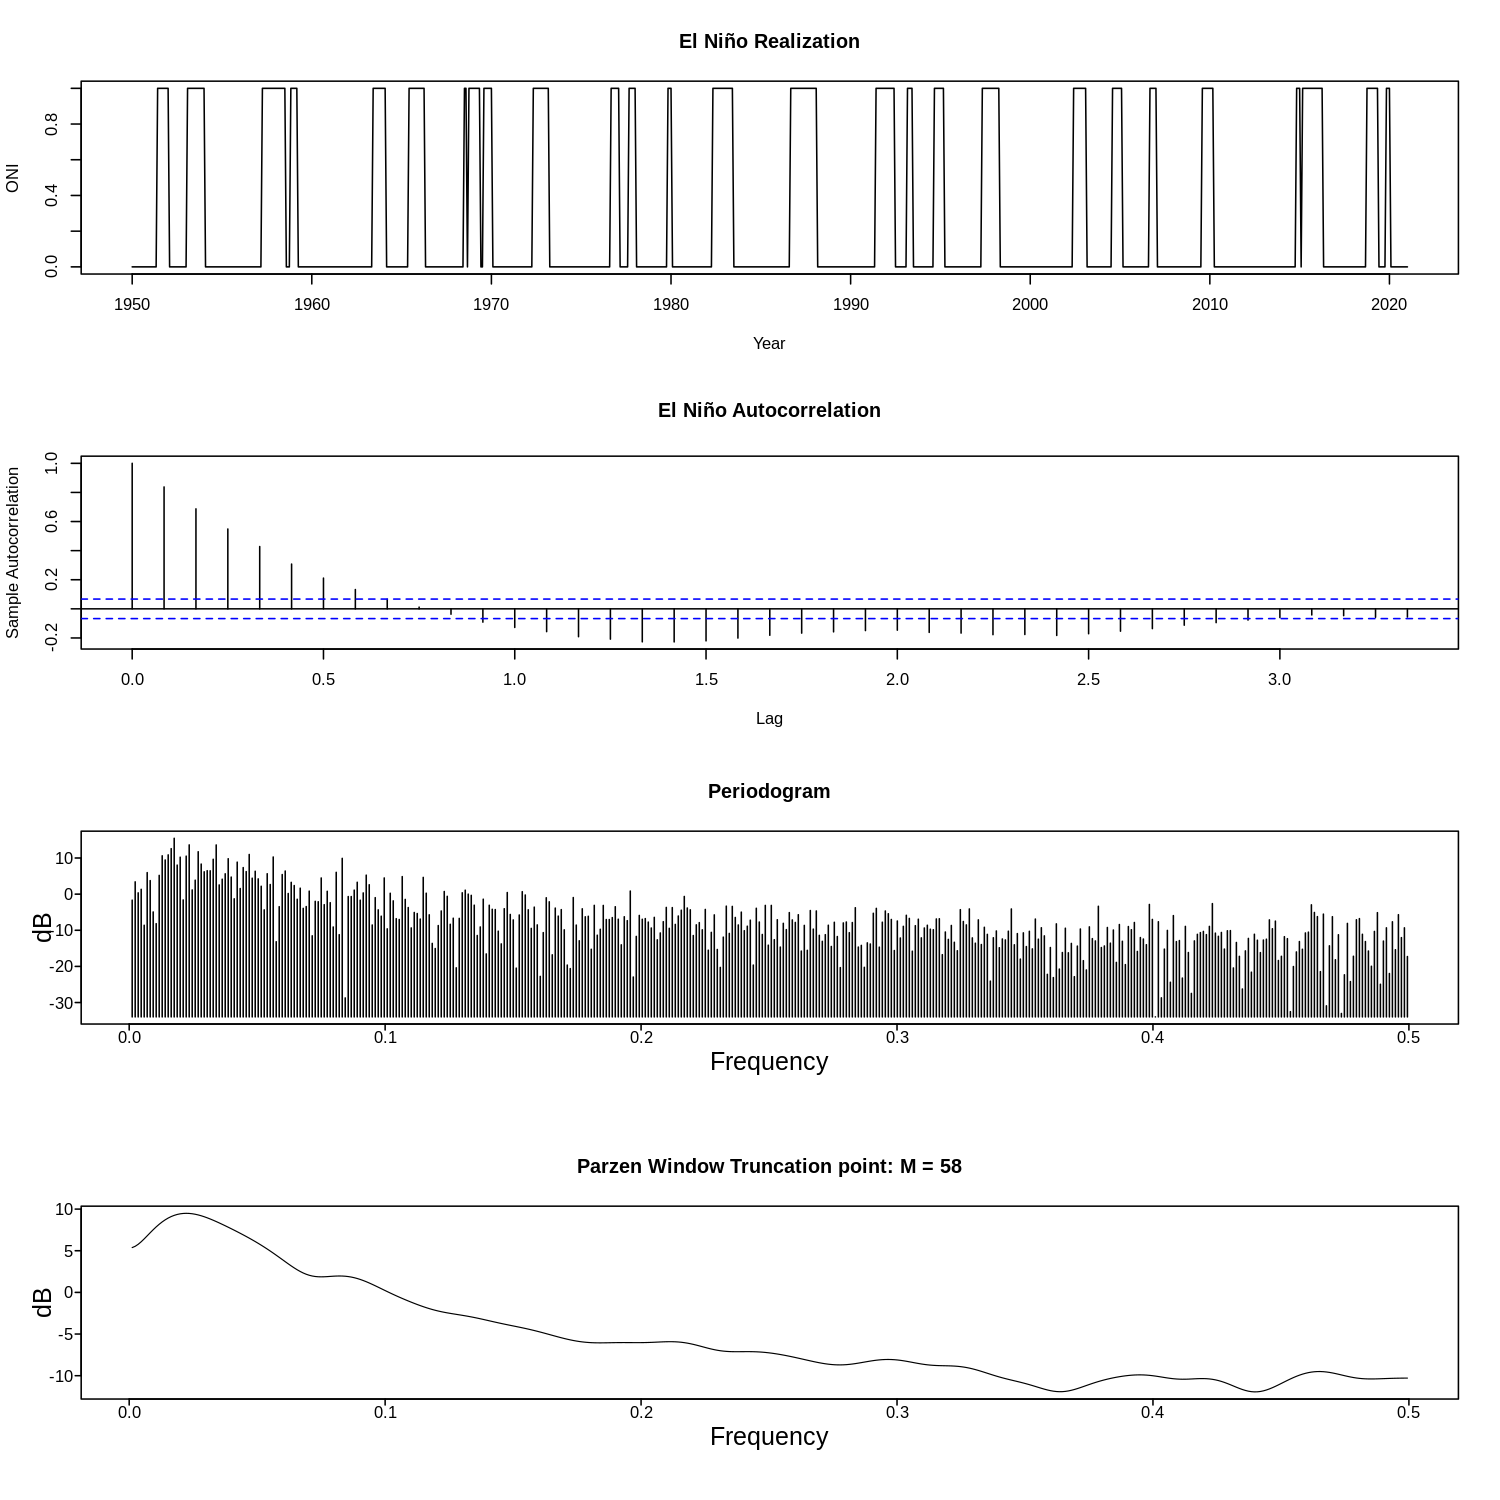

In [24]:
NinoMonthData.ts <- ts(Nino.data, start = 1950, frequency = 12)

exploritory.plots(NinoMonthData.ts, lag.max = 40, 
                                    l = FALSE,
                                    main.plot = "El Niño Realization", 
                                    main.acf = "El Niño Autocorrelation", 
                                    ylab = "ONI")

In [25]:
NinoMonthData.period <- period.wge(NinoMonthData.ts, plot = FALSE)

len <- length(NinoMonthData.period$pgram)

NinoMonthData.f1.index <- which.max(NinoMonthData.period$pgram)
NinoMonthData.f1 <- NinoMonthData.period$freq[NinoMonthData.f1.index]

cat('Frequency 1:', NinoMonthData.f1, '\n')
cat('Period 1:', 1/NinoMonthData.f1, '\n\n')

Frequency 1: 0.01758499 
Period 1: 56.86667 



As you can see in the plots above there is no dominant frequencies. Now lets look at an annualized version of the plot. Concidering a vector of years that cover our entire sample space a year was coded as a 1 if it was a year in which an El Niño event began and coded as a 0 if it was any other year.

In [26]:
totalYears <- c(1950:2021)
values <- c()

for (year in totalYears){

  if (year %in% startYears){
    values <- c(values, 1)
  }
  else{
    values <- c(values, 0)
  }
}

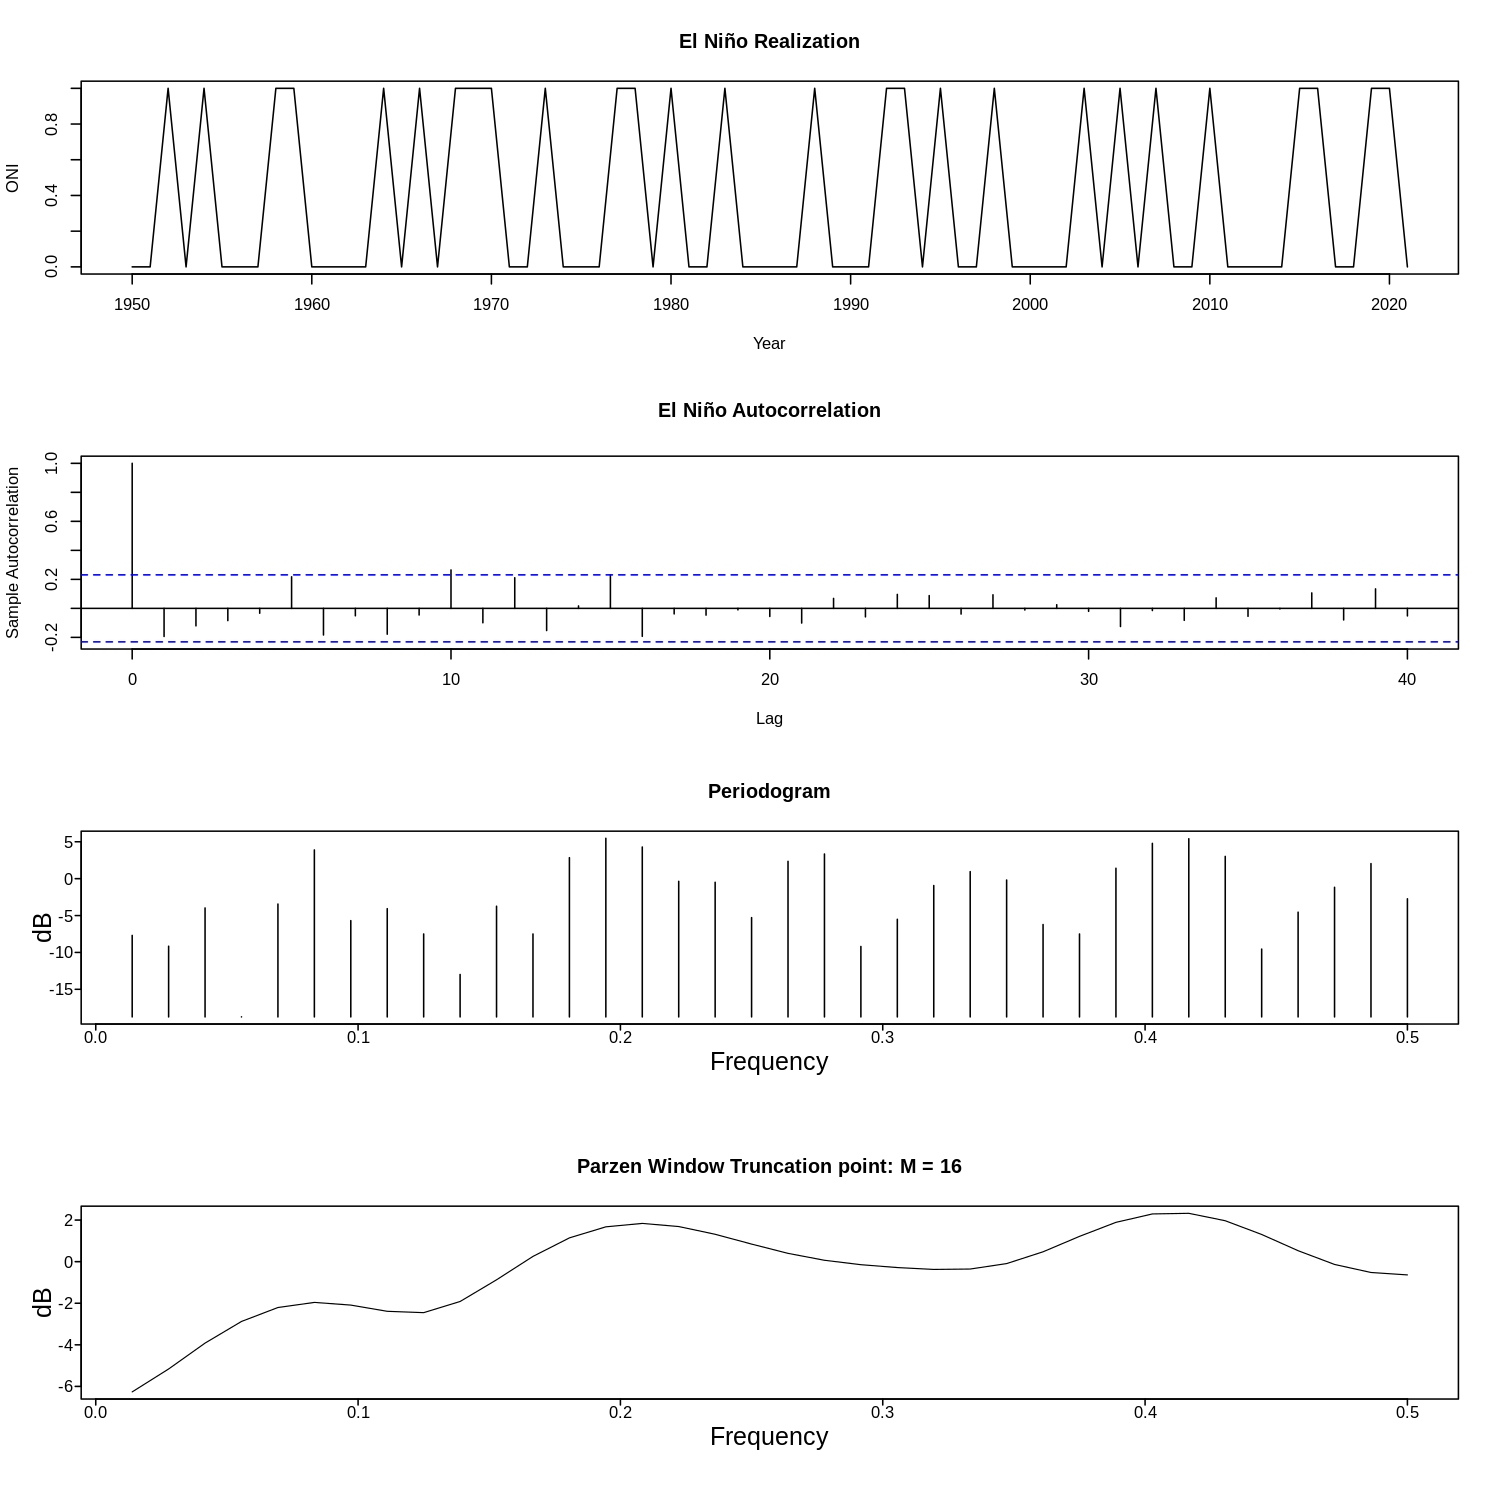

In [27]:
NinoYearData.ts <- ts(values, start = 1950, frequency = 1)

exploritory.plots(NinoYearData.ts, lag.max = 40, 
                                   l = FALSE,
                                   main.plot = "El Niño Realization", 
                                   main.acf = "El Niño Autocorrelation", 
                                   ylab = "ONI")

In [28]:
NinoYearData.period <- period.wge(NinoYearData.ts, plot = FALSE)

len <- length(NinoYearData.period$pgram)

NinoYearData.f1 <- NinoYearData.period$freq[6]

NinoYearData.f2 <- NinoYearData.period$freq[14]

NinoYearData.f3 <- NinoYearData.period$freq[30]

cat('Frequency 1:', NinoYearData.f1, '\n')
cat('Period 1:', 1/NinoYearData.f1, '\n\n')

cat('Frequency 2:', NinoYearData.f2, '\n')
cat('Period 2:', 1/NinoYearData.f2, '\n\n')

cat('Frequency 3:', NinoYearData.f3, '\n')
cat('Period 3:', 1/NinoYearData.f3, '\n\n')

Frequency 1: 0.08333333 
Period 1: 12 

Frequency 2: 0.1944444 
Period 2: 5.142857 

Frequency 3: 0.4166667 
Period 3: 2.4 



With the annulized plot we can clearly see three dominant frequencies. According to the dominant frequencies an El Nino event will take place every twelve, five, and two years which is fairly in line with other academic research.

### Daily Min Temp in Melbourne

For additional data analysis I found a data set that contained the daily minimum temperature in Melbourne, Austrailia between January 1, 2081 and December 31, 1990.

In [29]:
# load in mMlbourne Temperature dataset
address  <- "https://raw.githubusercontent.com"
username  <- "jbrownlee"
repo      <- "Datasets"
branch    <- "master"
file.name <- "daily-min-temperatures.csv"

Melbourne.location = paste(address, username, repo, branch, file.name, sep = '/')
Melbourne.df <- read.csv(Melbourne.location)

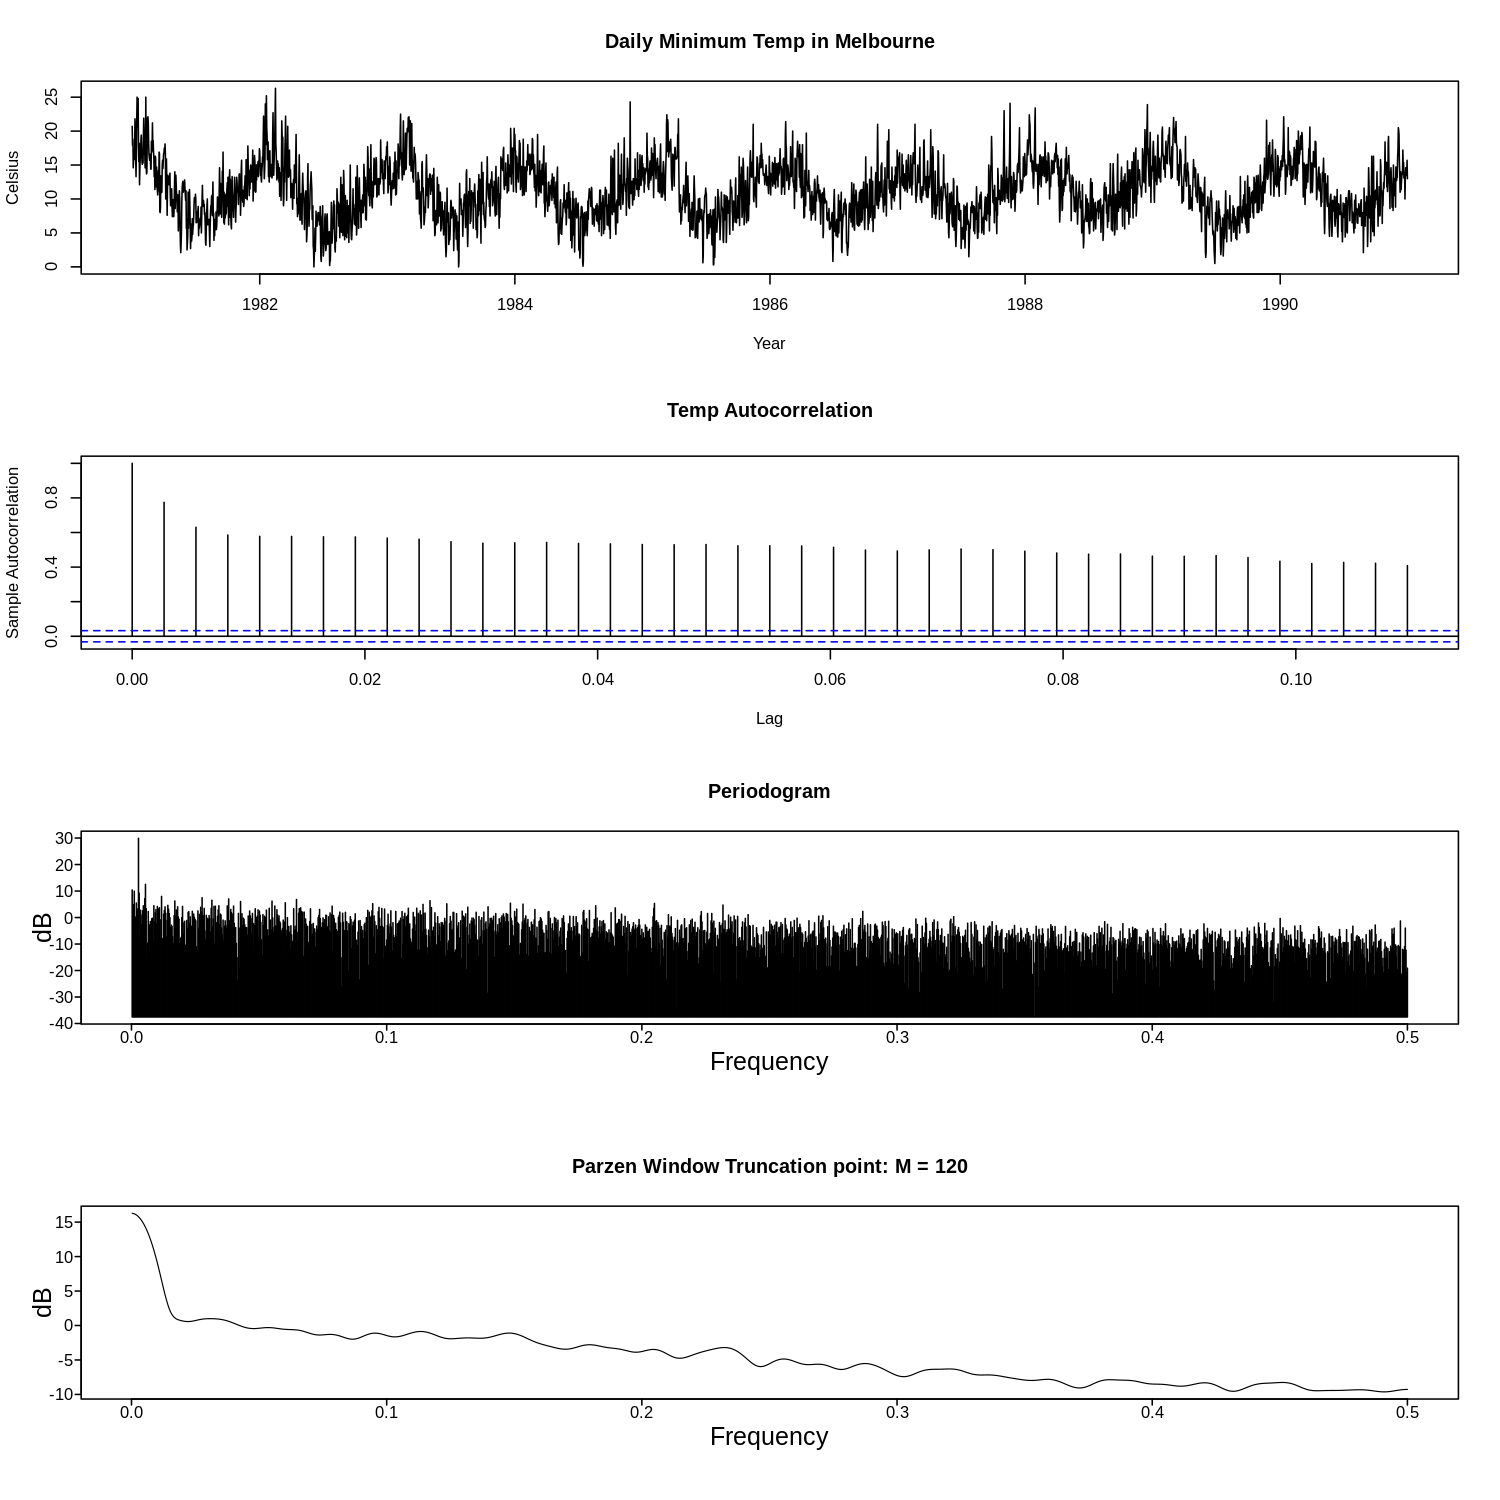

In [30]:
Melbourne.ts = ts(Melbourne.df$Temp, start = 1981, frequency = 365)

exploritory.plots(Melbourne.ts, lag.max = 40, 
                                l = FALSE,
                                main.plot = "Daily Minimum Temp in Melbourne", 
                                main.acf = "Temp Autocorrelation", 
                                ylab = "Celsius")

With daily temperatures it is hard to see any sort of dominant frequency. Lets look at average weekly temperatures.

In [31]:
numObservations <- length(Melbourne.df$Temp)
initialVector <- c(1:numObservations)

# subset on multiples of 7
# each element of the vector represents the thurday of each week
# 1981-01-01 the first data point was a thursday
sevenVector <- initialVector[(initialVector %% 7) == 1]

weeklyTemps <- c()

for (week in sevenVector){
  avgWeekTemp <- mean(Melbourne.df$Temp[week:week + 7])

  weeklyTemps <- c(weeklyTemps, avgWeekTemp)
}

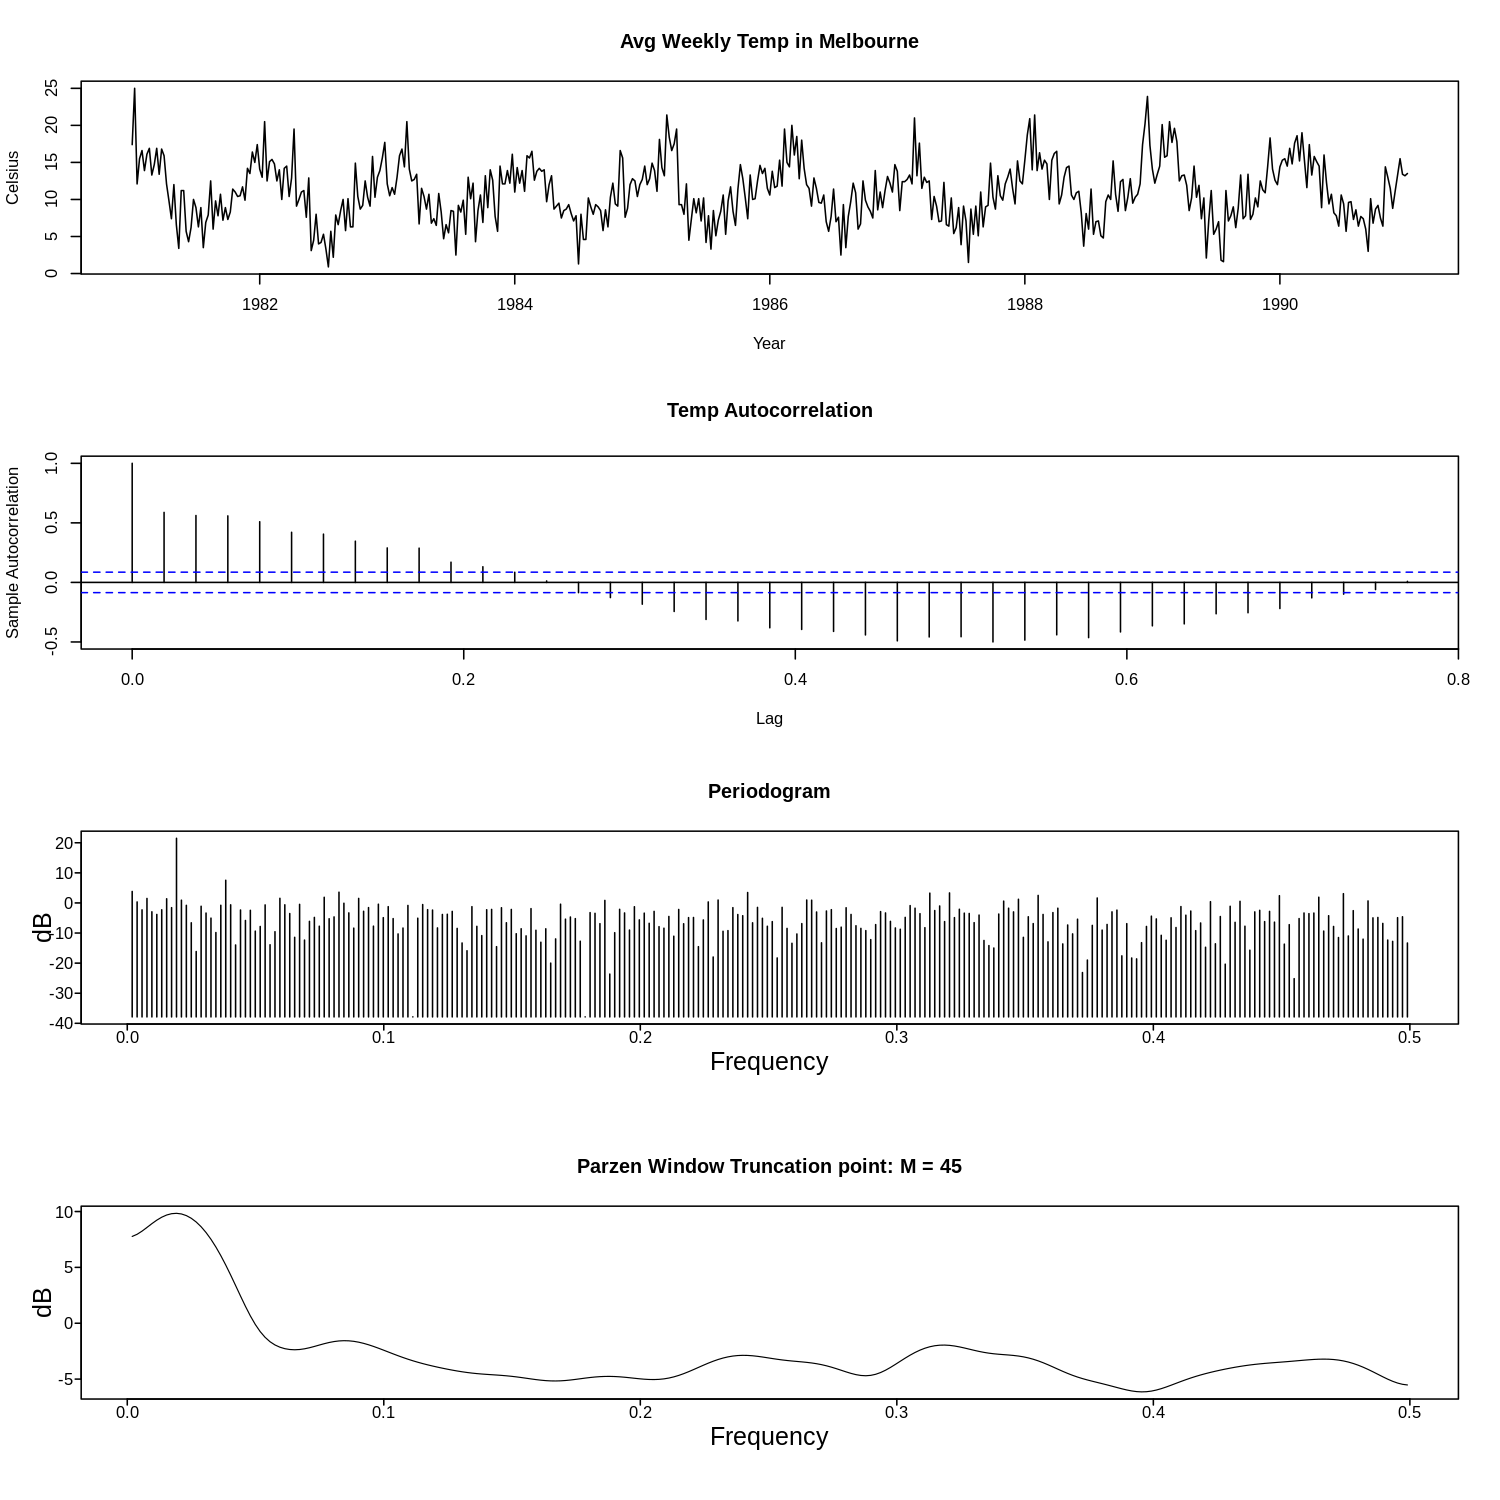

In [32]:
MelbourneWeek.ts = ts(weeklyTemps[1: length(weeklyTemps) - 1], start = 1981, frequency = 52)

exploritory.plots(MelbourneWeek.ts, lag.max = 40, 
                                     l = FALSE,
                                     main.plot = "Avg Weekly Temp in Melbourne", 
                                     main.acf = "Temp Autocorrelation", 
                                     ylab = "Celsius")

The dominant frequencies are starting to become a little more apparent. Lets look at average monthly temperatures.

In [33]:
# add a year and month column to data.frame
Melbourne.df$Year <- substr(Melbourne.df$Date, start = 1, stop = 4)
Melbourne.df$Month <- substr(Melbourne.df$Date, start = 6, stop = 7)

# create new data.frame for average montly temps
monthRep <- c('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12')
mMonths <- rep(monthRep, times = length(1981:1990))
mYears <- rep(c(as.character(1981:1990)), each = 12)
monthlyTemp <- data.frame(mYears, mMonths)

# vector to store average monthly temps
temps <- c()

# iterate through data.frame
for (row in 1:nrow(monthlyTemp)){
  
  # calculate mean temperature for specific month and specific year
  data <- monthlyTemp[row, ]
  criteria <- Melbourne.df$Year == data$mYears & Melbourne.df$Month == data$mMonths
  temps <- c(temps, mean(Melbourne.df[criteria, ]$Temp))

}

# append column to data.frame
monthlyTemp$Temp <- temps

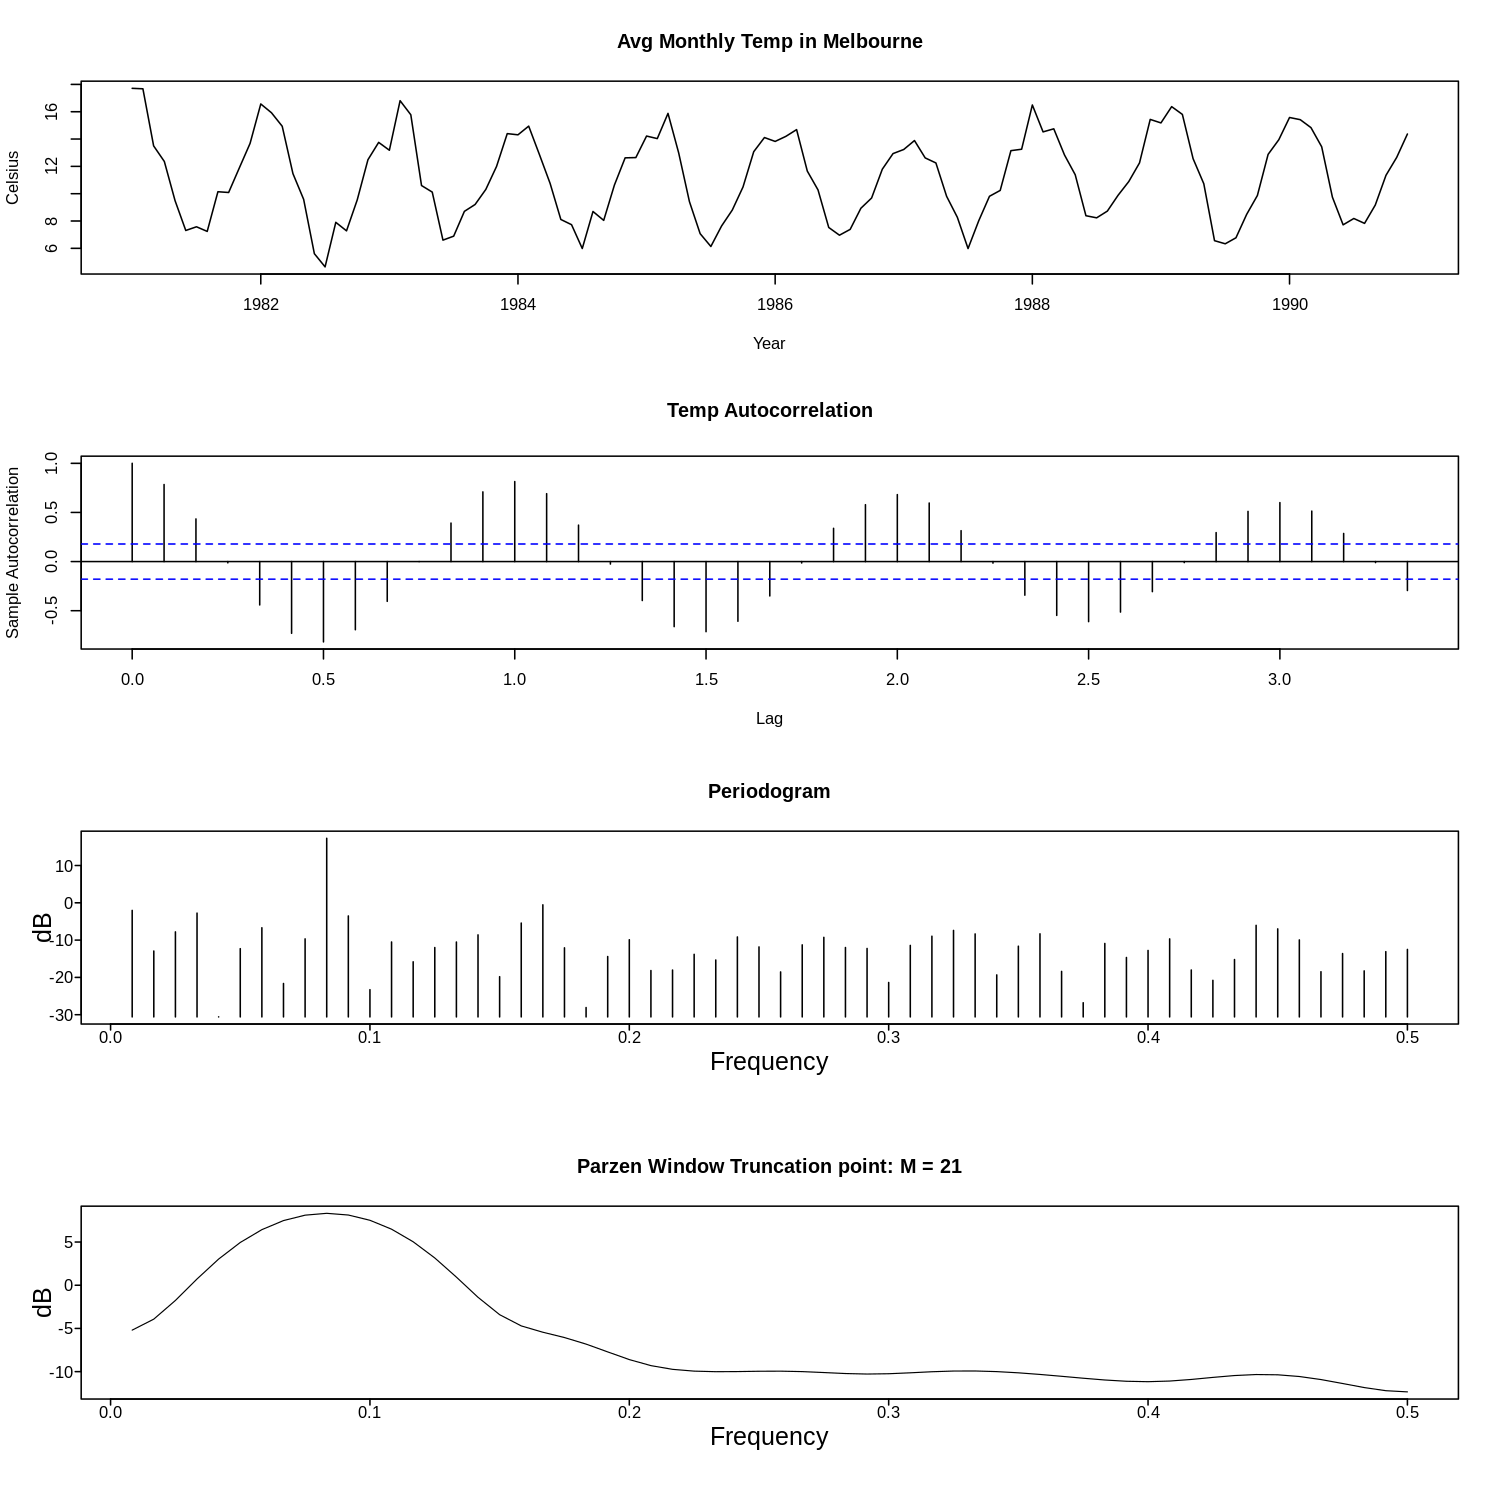

In [34]:
MelbourneMonth.ts = ts(monthlyTemp$Temp, start = 1981, frequency = 12)

exploritory.plots(MelbourneMonth.ts, lag.max = 40, 
                                     l = FALSE,
                                     main.plot = "Avg Monthly Temp in Melbourne", 
                                     main.acf = "Temp Autocorrelation", 
                                     ylab = "Celsius")

In [35]:
MelbourneMonth.period <- period.wge(MelbourneMonth.ts, plot = FALSE)

MelbourneMonth.f1.index <- which.max(MelbourneMonth.period$pgram)
MelbourneMonth.f1 <- MelbourneMonth.period$freq[MelbourneMonth.f1.index]

cat('Frequency 1:', MelbourneMonth.f1, '\n')
cat('Period 1:', 1/MelbourneMonth.f1, '\n\n')

Frequency 1: 0.08333333 
Period 1: 12 



Now we can see a very clear dominant frequency representing an expected period of every twelve months.

### Conclusion

In Lab 1 I processed and loaded three data sets. I replicated a figure from the original research paper. I explored the periodogram and autocorrelation plots for each data set. I programmatically calculated the years in which the El Niño events began. I analyzed temperature data from Melbourne, Australia. Throughout my analysis the periodogram and spectral density plot were my main tools for identifying dominant frequencies in the time series data. Visualizing the data with the spectral density plot made understanding the patterns in the data intuitive. Manipulating the data programmatically to analyses different frequencies was the most challenging and rewarding part of the lab.

### References

* Wayne Woodward (2016). tswge: Applied Time Series Analysis. R package version 1.0.0. https://CRAN.R-project.org/package=tswge

* Lam, Holly C.Y.; Haines, Andy; McGregor, Glenn; Chan, Emily Y.Y.; Hajat, Shakoor. 2019. "Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle" *Int. J. Environ. Res. Public Health* 16, no. 17: 3146. https://doi.org/10.3390/ijerph16173146

* Daily minimum temperatures in Melbourne, Australia, 1981-1990 Source: Time Series Data Library (citing: Australian Bureau of Meteorology)
